In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
import matplotlib
from matplotlib import pylab
import seaborn

In [3]:
import numpy
import pandas
import itertools
import functools

In [4]:
import jug

In [63]:
jug.init("sequence_protease_susceptibility_analysis.py")
import sequence_protease_susceptibility_analysis

In [64]:
NOLOAD = object()
def incremental_value(elem):
    if isinstance(elem, jug.task.TaskBase):
        return elem.value() if elem.can_load() else NOLOAD
    elif isinstance(elem, list):
        return [
            v for v in map(incremental_value, elem) if v is not NOLOAD
        ]
    elif isinstance(elem, tuple):
        rv = map(incremental_value, elem)
        assert all(v is not NOLOAD for v in rv)
        return rv
    elif isinstance(elem, dict):
        return {
            k : v for k, v in 
            zip(elem.keys(), map(incremental_value, elem.values()))
            if v is not NOLOAD
        }
    else:
        return elem

In [70]:
results = incremental_value( sequence_protease_susceptibility_analysis.model_results )

In [71]:
rmse = lambda v: numpy.sqrt( numpy.mean( numpy.square(v) ) )

In [72]:
import toolz.dicttoolz as dicttoolz

In [73]:
rframe = pandas.DataFrame.from_records([
    dicttoolz.merge(
        p,
        dict(
            protease = d,
            rmsd = rmse(v.eval("ec50 - pred_ec50"))
        ))
    for (d, p), v in results.items()
])

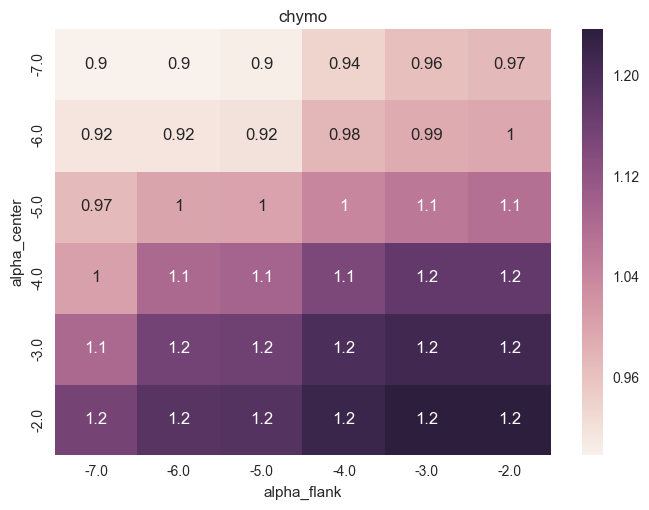

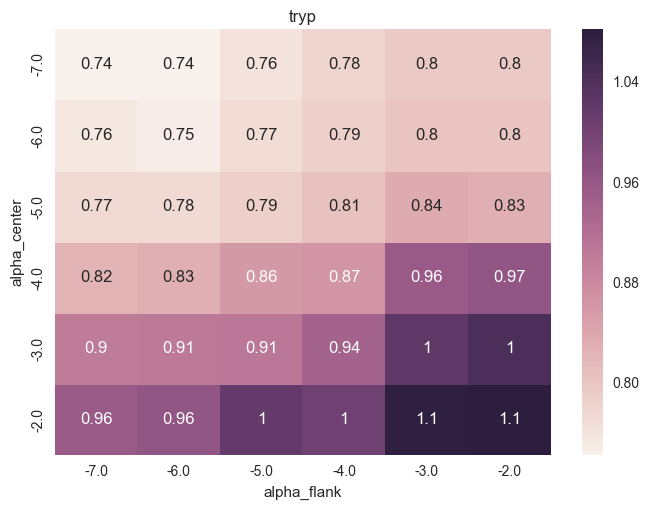

In [74]:
for p in rframe.protease.unique():
    pylab.figure()
    
    tf = rframe[rframe.protease == p].pivot("alpha_center", "alpha_flank", "rmsd")
    tf.columns.values[:] = numpy.log(tf.columns.values)
    tf.index.values[:] = numpy.log(tf.index.values)

    seaborn.heatmap(
        tf, annot=True, robust=True
    )
    
    pylab.title(p)